# Modelowanie ARMA

In [135]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

#from ts_utils import check_time_series_stationary
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.arima.model import ARIMA

In [136]:
from statsmodels.tsa.stattools import adfuller
def check_time_series_stationary(y, rolling_len = 12):
    
    y = pd.Series(y)
    
    df_test = adfuller(y)
    
    if df_test[1] < 0.05:
        print('Szereg jest stacjonarny')
    else:
        print('Szereg jest niestacjonarny')
    
    print("{0:^32s}".format("Dickey-Fuller Test"))
    print("-"*32+"\n")
    
    print("{0:<20s}: {1:>10.4f}".format('Test Statistic', df_test[0]))
    print("{0:<20s}: {1:>10.4f}".format('p-value', df_test[1]))
    print("-"*32+"\n")
    
    rolling_mean = y.rolling(rolling_len).mean()
    rolling_var = y.rolling(rolling_len).var()

    plt.plot(y)
    plt.plot(rolling_mean, label="Rolling mean")
    plt.plot(rolling_var, label="Rolling var")
    plt.legend()
    plt.show()
    
    print("{0:^32s}".format("Autocorrelation plot"))
    print("-"*32+"\n")
    pd.plotting.autocorrelation_plot(y)
    plt.show()

## Zadanie 1

Dokonaj analizy szeregu czasowego `Usgdp`. Dopasuj odpowiedni model i dokonaj predykcji.

In [144]:
usgdp = pd.read_csv('USGDP.csv', 
                 parse_dates=['DATE'], index_col='DATE')

usgdp.head()

,GDPC1
DATE,
1947-01-01,2033.061
1947-04-01,2027.639
1947-07-01,2023.452
1947-10-01,2055.103
1948-01-01,2086.017


Szereg jest niestacjonarny
       Dickey-Fuller Test       
--------------------------------

Test Statistic      :     2.9819
p-value             :     1.0000
--------------------------------



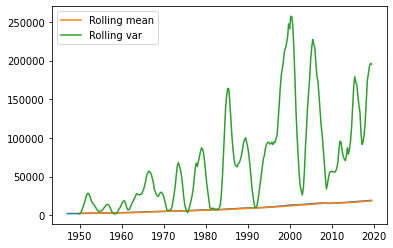

      Autocorrelation plot      
--------------------------------



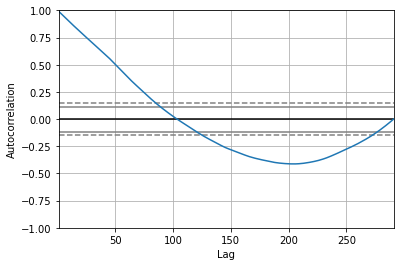

In [145]:
check_time_series_stationary(usgdp.GDPC1)

In [146]:
log_usgdp = np.log(usgdp) #logarytm używamy aby pozbyć się z szeregu wariancji zmieniającej się w czasie

Szereg jest niestacjonarny
       Dickey-Fuller Test       
--------------------------------

Test Statistic      :    -2.1605
p-value             :     0.2209
--------------------------------



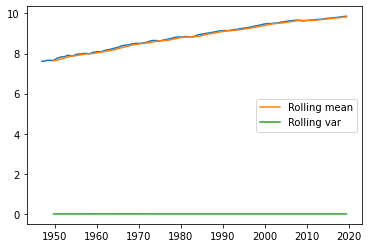

      Autocorrelation plot      
--------------------------------



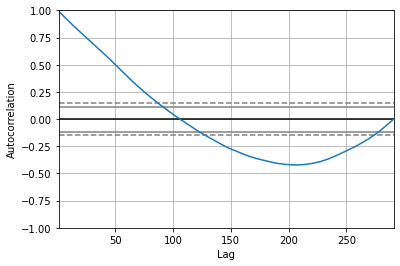

In [147]:
check_time_series_stationary(log_usgdp.GDPC1)

In [148]:
log_usgdp_diff = log_usgdp.diff(1).dropna() #różnicujemy aby pozbyć się trendu

Szereg jest stacjonarny
       Dickey-Fuller Test       
--------------------------------

Test Statistic      :    -8.4548
p-value             :     0.0000
--------------------------------



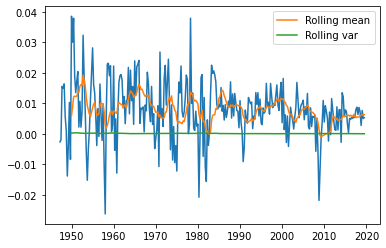

      Autocorrelation plot      
--------------------------------



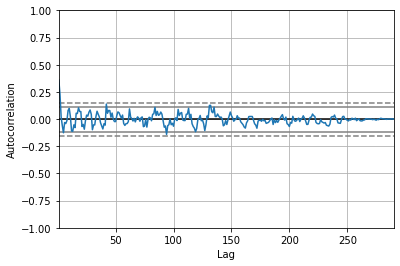

In [149]:
check_time_series_stationary(log_usgdp_diff.GDPC1) #stacjonarny

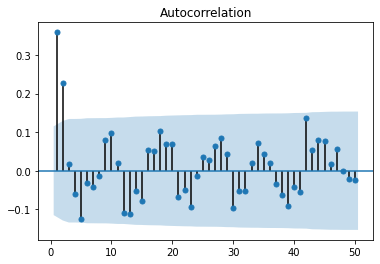

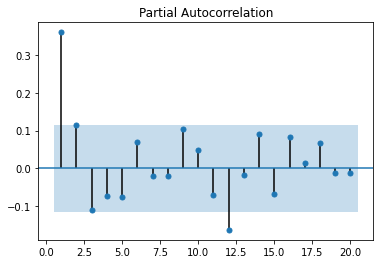

In [150]:
plot_acf(log_usgdp_diff.GDPC1,lags = 50,zero=False)
plt.show()

plot_pacf(log_usgdp_diff.GDPC1,lags = 20,zero=False)
plt.show()

# MA => ACF
# AR => PACF

In [151]:
arma = ARIMA(endog = log_usgdp_diff,order = (1,0,2)) #arma na zróżnicowanym szeregu
# order = (p,d,q) p - AR, d - roznicowania, q - MA

In [152]:
arma2 = ARIMA(endog = log_usgdp,order = (1,1,2),trend = 't') #arima na wyjściowym szeregu
arma2 = arma2.fit()

In [153]:
arma2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  GDPC1   No. Observations:                  291
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 969.011
Date:                Mon, 19 Dec 2022   AIC                          -1928.021
Time:                        00:24:06   BIC                          -1909.672
Sample:                    01-01-1947   HQIC                         -1920.670
                         - 07-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0077      0.001      8.600      0.000       0.006       0.009
ar.L1          0.3200      0.200      1.601      0.109      -0.072       0.712
ma.L1          0.0064      0.200      0.032      0.975      -0.386       0.399
ma.L2          0.1675      0.068      2.455      0.014       0.034       0.301
sigma2       7.32e-05   4.31e-06     16.996      0.000    6.48e-05    8.16e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                54.03
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.25   Skew:                             0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [154]:
arma2.params #współczynniki ARIMA(1,1,2)

x1        0.007681
ar.L1     0.319970
ma.L1     0.006398
ma.L2     0.167497
sigma2    0.000073
dtype: float64

In [155]:
arma2.arparams #parametry części AR w ARIMA

array([0.31997043])

In [156]:
arma2.maparams #parametry części MA w ARIMA

array([0.00639841, 0.16749741])

In [157]:
(arma2.aic, arma2.bic) #wartość kryteriów AIC i BIC

(-1928.021476498801, -1909.6720718838983)

In [158]:
arma2.predict() # wartosci dopasowane do modelu - domyślnie dynamic=False, co oznacza, że zawsze kolejne przewidywanie 
                #w modelu jest liczone przy użyciu wiedzy o wszystkich wcześniejszych danych

1947-01-01    0.007681
1947-04-01    7.624979
1947-07-01    7.618465
1947-10-01    7.615670
1948-01-01    7.637401
                ...   
2018-07-01    9.838491
2018-10-01    9.845757
2019-01-01    9.846717
2019-04-01    9.855192
2019-07-01    9.860426
Freq: QS-OCT, Name: predicted_mean, Length: 291, dtype: float64

In [159]:
arma2.resid # Y_t - \hat{T}_t #rezydua

DATE
1947-01-01    7.609617
1947-04-01   -0.010352
1947-07-01   -0.005904
1947-10-01    0.012411
1948-01-01    0.005611
                ...   
2018-07-01   -0.000464
2018-10-01   -0.005020
2019-01-01    0.001642
2019-04-01   -0.001848
2019-07-01   -0.001828
Length: 291, dtype: float64

In [160]:
arma2.forecast(steps=1)[0] # przewidziana wartość na kolejny rok (ten który następuje po ostatnim zaobserwowanym roku)

9.865181288992996

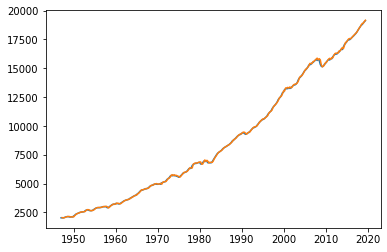

In [161]:
plt.plot(usgdp.index,usgdp.GDPC1)
plt.plot(usgdp.index[1:],np.exp(arma2.predict())[1:]) #bierzemy szystko oprócz pierwszej wartości, bo nasz model zakłada różnicowanie, 
                                                      #przez co musi przewidywać jedną wartość wstecz, nie bierzemy jej do oceny jakości
                                                      #dopasowania.
                                                      #wartości dopasowane traktujemy f. wykładniczą, 
                                                      #bo model robiliśmy na zlogarytmizowanym szeregu 
#szereg (niebieska linia) i wartości dopasowane (pomarańczowa linia) - model dobrze dopasowany

### Dopasowanie modelu

Diagnostyka modelu sprowadza się m.in do:
- analizy reszt - jeśli dopadowany model poprawnie wyjaśnia dynamikę czasową analizowanego zjawiska, w szeregu reszt nie powinno być widać żadnych regularnych zachowań (trendu, sezonowości), ani istotnej korelacji czasowej (dla żadnego z opóźnień), stąd:
    - w praktyce możemy posługiwać się regułą, że reszty dopasowanego modelu powinny zachowywać się w przybliżeniu jak biały szum,
    - często weryfikujemy również dodatkowo, czy rozkład reszt można uznawać za rozkład normalny
    
W praktyce sprawdzamy najczęściej 
- wykres reszt - na wykresie nie powinno być widocznych regularnych wzorów ani niejednorodności wariancji, 
- test Durbina-Watsona - niezależność błędów obserwacji, dobrze dopasowany model zakłada, że otrzymywane reszty są niezależne od siebie, innymi słowy, rozkład ich jest losowy, przypadkowy, bez stale występującego wzorca. 
- ACF/PACF dla reszt - na wykresach nie powinno być widocznych istotnych korelacji (tzw. *graficzny test białoszumowości*),
- weryfikacja normalności rozkładu reszt - wykorzystujemy narzędzia graficzne (np. Q-Q plot lub histogram) oraz formalne testy statystyczne normalności (np. test Shapiro-Wilka).

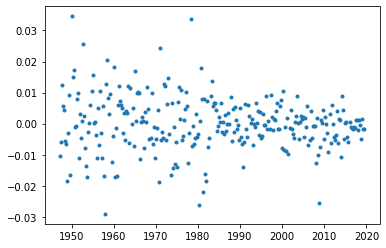

In [170]:
plt.plot(arma2.resid[1:], '.') # powinny ukladac sie losowo wokół y = 0, wygląda ok
plt.show()

### Test Durbina-Watsona

Statystyka DW mieści się w przedziale od 0 do 4:
- w przypadku DW > 2, zakłada się występowanie autokorelacji ujemnej, 
- w przypadku DW < 2 autokorelacji dodatniej,
- wartości zbliżone do 2 oznaczają brak występowania autokorelacji. 

In [171]:
sm.stats.durbin_watson(arma2.resid[1:]) # zakładmy, że reszty nie sa skorelowane

1.9953296542569101

### Wykres reszt za pomocą ACF i PACF

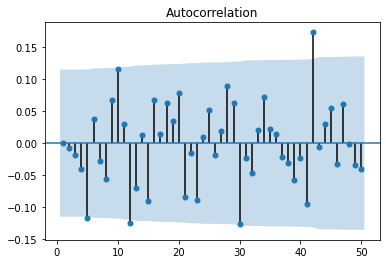

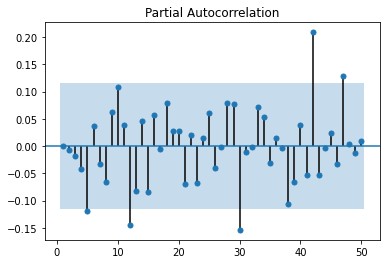

In [172]:
plot_acf(arma2.resid[1:], lags=50, zero=False)
plt.show()

plot_pacf(arma2.resid[1:], lags=50, zero=False)
plt.show()
#jeśli chodzi o acfy to część jest na granicy, ale może to być biały szum

### Weryfikacja normalności rozkładu reszt

1. Test Shapiro-Wilka

    H0: Rozkład badanej cechy jest rozkładem normalnym.

    H1: Rozkład badanej cechy nie jest rozkładem normalnym.
    

2. Wykres $Q-Q$

In [173]:
# test shapiro-wilka
stats.shapiro(arma2.resid[1:])[1] #pwartosc
# pvalue < 0.05 => odrzucamy H0 => reszty nie maja rozkladu normalnego

1.220110607391689e-05

In [174]:
# test omnimbusa
stats.normaltest(arma2.resid[1:])
# pvalue < 0.05 => odrzucamy H0 => reszty nie maja rozkladu normalnego

NormaltestResult(statistic=19.060819657791576, pvalue=7.260986027499278e-05)

In [175]:
# wykres Q-Q

from statsmodels.graphics.api import qqplot

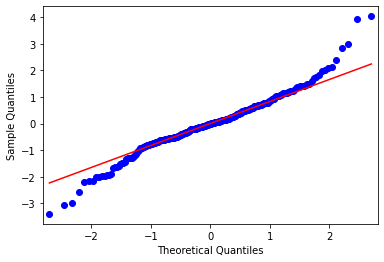

In [176]:
qqplot(arma2.resid[1:], line='q', fit=True)
plt.show() #ogony nie są normalne

In [ ]:
# wniosek: mamy biały szum co jest dobrym wynikiem, ale nie jest to biały szum o rozkładzie normalnym

### Analiza istotności współczynników w modelu

Jakość dopasowania modelu można niekiedy poprawić eliminując te współczynniki, które są statystycznie nieistotne, to znaczy nie odgrywają istotnej roli w wyjaśnianiu dynamiki czasowej modelowanego zjawiska.

Formalnie, sprawdzamy hipotezę zerową postaci 
$$H_0: \phi_i = 0,$$
kontra hipotezie alternatywnej 
$$H_1: \phi_i \neq 0$$.

Odrzucenie $H_0$ przemawia za pozostawieniem współczynnika $\phi_i$ w modelu.

In [177]:
arma2.summary() #nieistotne ar.L1 i ma.L1

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  GDPC1   No. Observations:                  291
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 969.011
Date:                Mon, 19 Dec 2022   AIC                          -1928.021
Time:                        00:26:31   BIC                          -1909.672
Sample:                    01-01-1947   HQIC                         -1920.670
                         - 07-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0077      0.001      8.600      0.000       0.006       0.009
ar.L1          0.3200      0.200      1.601      0.109      -0.072       0.712
ma.L1          0.0064      0.200      0.032      0.975      -0.386       0.399
ma.L2          0.1675      0.068      2.455      0.014       0.034       0.301
sigma2       7.32e-05   4.31e-06     16.996      0.000    6.48e-05    8.16e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                54.03
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.25   Skew:                             0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Dopasowanie (Predykcja) na podstawie modelu

In [ ]:
?ar2.predict

# dynamic : bool, optional
#     The `dynamic` keyword affects in-sample prediction. 
#     If dynamic is False, then the in-sample lagged values are used for
#     prediction. 
    
#     If `dynamic` is True, then in-sample forecasts are
#     used in place of lagged dependent variables. The first forecasted
#     value is `start`.

In [178]:
predict_logusgdp_dynamic = arma2.predict(start = '2010-01-01',dynamic=True) #dynamic true daje nam po prostu przewidywania modelu poczynając od jakiegoś punktu startowego
#dynamic false, robi nam prognozę na podstawie wszystkich danych wartości szeregu, które indeks czasowy mają wcześniej

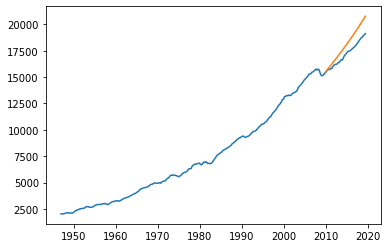

In [179]:
#tu mamy wykres szeregu i prognoza uzyskana dla danych od 2010 roku na modelu dopasowanym na czałym szeregu
#do pełnej oceny zdolności predykcyjnej (kolejny zestaw) brakuje nam tutaj tego aby model był uczony tylko na tej części gdzie nie liczymy predykcji
plt.plot(usgdp.index,usgdp.GDPC1)
plt.plot(usgdp.index[usgdp.index>='2010-01-01'],np.exp(predict_logusgdp_dynamic))
plt.show() #jak robimy prognozy na kilka kroków do przodu nie aktualizując danych w każdym kroku, 
#to to na co wskazuje model może się róznić od prawdziwych wartości i ta różnica może rosnąć w czasie, aczkolwiek taki sposób predykcji
#jest bliższy temu którego używa się w ocenianiu jakości predykcji modelu

## Zadanie 2
Dla danych

1. `southern`

2. `daily-total-female-births`

dopasuj odpowiedni model $\text{AR}(p)$ lub $\text{MA}(q)$ lub $\text{ARMA}(p, q)$ (rząd $p$ i $q$ wyznacz na podstawie wykresów ACF i PACF). Sprawdź dopasowanie modeli.

In [180]:
daily_biths = pd.read_csv('daily-total-female-births.csv', 
                 parse_dates=['Date'], index_col='Date')

daily_biths.head()

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


In [181]:
daily_biths.index

DatetimeIndex(['1959-01-01', '1959-01-02', '1959-01-03', '1959-01-04',
               '1959-01-05', '1959-01-06', '1959-01-07', '1959-01-08',
               '1959-01-09', '1959-01-10',
               ...
               '1959-12-22', '1959-12-23', '1959-12-24', '1959-12-25',
               '1959-12-26', '1959-12-27', '1959-12-28', '1959-12-29',
               '1959-12-30', '1959-12-31'],
              dtype='datetime64[ns]', name='Date', length=365, freq=None)

Szereg jest stacjonarny
       Dickey-Fuller Test       
--------------------------------

Test Statistic      :    -4.8083
p-value             :     0.0001
--------------------------------



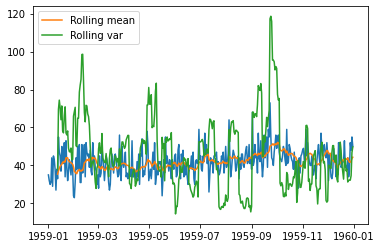

      Autocorrelation plot      
--------------------------------



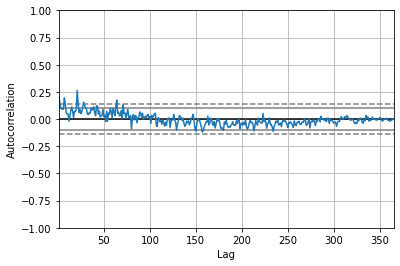

In [182]:
check_time_series_stationary(daily_biths.Births) #całkiem stacjonarny

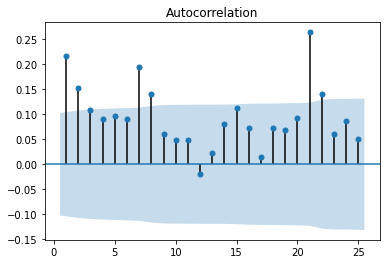

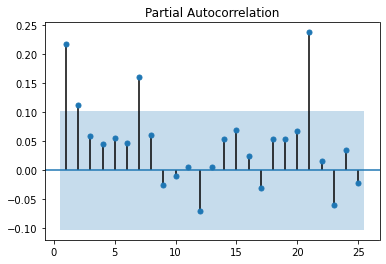

In [183]:
plot_acf(daily_biths, lags=25, zero=False)
plt.show()

plot_pacf(daily_biths, lags=25, zero=False)
plt.show()
#PACFY sugerują AR(7)

In [184]:
ar7 = ARIMA(daily_biths, order=(7, 0, 0)).fit()
ar7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Births   No. Observations:                  365
Model:                 ARIMA(7, 0, 0)   Log Likelihood               -1227.389
Date:                Mon, 19 Dec 2022   AIC                           2472.778
Time:                        00:27:49   BIC                           2507.877
Sample:                    01-01-1959   HQIC                          2486.727
                         - 12-31-1959                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.9580      0.852     49.260      0.000      40.289      43.627
ar.L1          0.1708      0.057      3.013      0.003       0.060       0.282
ar.L2          0.0853      0.055      1.556      0.120      -0.022       0.193
ar.L3          0.0390      0.054      0.718      0.473      -0.067       0.146
ar.L4          0.0293      0.060      0.492      0.623      -0.088       0.146
ar.L5          0.0347      0.057      0.606      0.544      -0.077       0.147
ar.L6          0.0211      0.060      0.348      0.727      -0.097       0.139
ar.L7          0.1614      0.050      3.210      0.001       0.063       0.260
sigma2        48.7483      3.705     13.158      0.000      41.487      56.010
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                15.90
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                             0.47
Prob(H) (two-sided):                  0.51   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

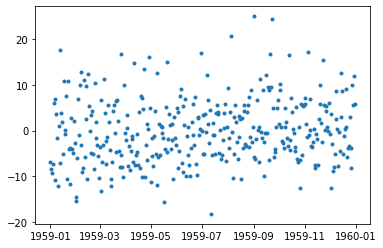

In [185]:
plt.plot(ar7.resid, '.')
plt.show() #wygląda ok

In [186]:
stats.shapiro(ar7.resid) #nie ma normalności

ShapiroResult(statistic=0.986261248588562, pvalue=0.0015482959570363164)

In [187]:
stats.normaltest(ar7.resid)#nie ma normalności

NormaltestResult(statistic=15.040606457431451, pvalue=0.0005419682006053038)

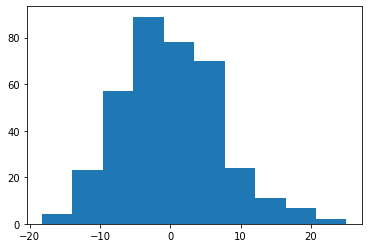

In [188]:
plt.hist(ar7.resid)
plt.show() #trochę skośny

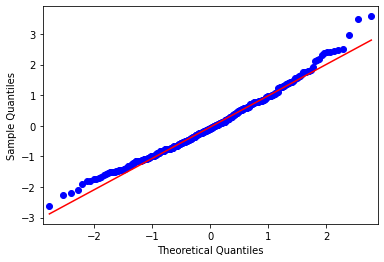

In [189]:
qqplot(ar7.resid, line='q', fit=True)
plt.show() #końcówki za mocno odbiegają

In [190]:
sm.stats.durbin_watson(ar7.resid) # zakladmy, ze reszty nie sa skorelowane

2.0144894174905073

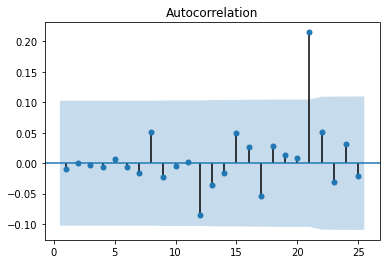

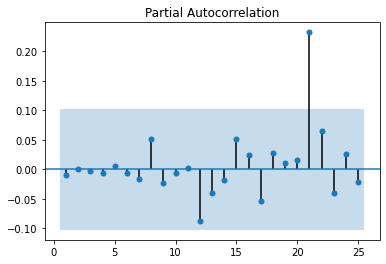

19.1049731745428

In [191]:
plot_acf(ar7.resid, lags=25, zero=False)
plt.show()

plot_pacf(ar7.resid, lags=25, zero=False)
plt.show()
#z grubsza biały szum
np.sqrt(len(ar7.resid)) #bo patrzymy na pierwsze 19 autokorelacji (sqrt(n))

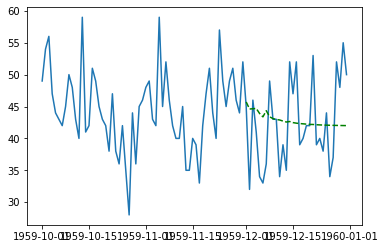

In [192]:
predict_births_dynamic = ar7.predict(start='1959-12-01', end='1959-12-31', dynamic=True)

plt.plot(daily_biths.loc['1959-10-01':])
plt.plot(predict_births_dynamic, 'g--')
plt.show() #dopasowanie mniej więcej ok bo fluktuacje są efektem zwykłej losowości

# Kryteria informacyjne oceniają jakość dopasowania modelu

Kryteria informacyjne oceniają jakość dopasowania modelu na podstawie danych historycznych, kontrolując jednocześnie stopień złożoności modelu. 

Zwiększając liczbę parametrów modelu (zwiększając złożoność modelu), możemy zazwyczaj otrzymać lepsze dopasowanie modelu do danych. Zbyt dobre dopasowanie modelu może jednak powodować problemy, a w szczególności może prowadzić do złych prognoz. Z tego powodu w postaci kryteriów wyboru modelu występuje składnik kary za wymiar modelu, w ogólności:

$$C(\text{model}) = -2 \ln(L) + \text{kara(liczba współczynników modelu)},$$
gdzie $L$ oznacza funkcję wiarogodności.

**AIC (Akaike Information Criterium)**
$$AIC(p, q) = -2 \ln(L) + 2\cdot(p+q+1)$$

**BIC (Bayesian Information Criterium)**
$$BIC(p, q) = -2 \ln(L) + (p+q+1)\cdot\ln n$$

### Kryteria oceniające dokładność prognoz 

- MSE - Mean Squared Error
- MAE - Median Absolute Error

Należy jednak pamiętać, że w odróżnieniu od kryteriów infromacyjnych, kryteria oparte na błędach predykcji nie mają wbudowanego mechanizmu, który "karałby" za złożoność modelu.

## Zadanie 3

Napisz funkcję, która dla dowolnego szeregu czasowego i modelu `ARMA` sprawdzi jego dopasowanie oraz jakość predykcji na podstawie MSE i MAE.
Zawrzyj informację o wartości oszacowanych współczynników modelu, wartości AIC i BIC, wartości statystyki Durbina-Watsona oraz ocenę normalności reszt.

Następnie sprawdź dopasowanie dla kilku wybranych modeli ARMA.

In [193]:
def mse(y, yhat):
    return np.mean((y - yhat) ** 2)

def mae(y, yhat):
    return np.median(np.abs(y - yhat))

In [194]:
def fit_ARMA(ts, p, q, pred_start, pred_end):
    arma = ARIMA(ts, order=(p, 0, q)).fit()
  
    
    print('AIC: %.2f, \nBIC: %.2f' % (arma.aic, arma.bic))
    
    dw_test = sm.stats.durbin_watson(arma.resid)
    print("Statystyka Durbina-Watsona {}".format(dw_test))
    
    normal_test = stats.shapiro(arma.resid)
    print("Pvalue testu Shapiro-Wilka: {}".format(normal_test[1]))
    
    pred = arma.predict(start=pred_start, end=pred_end,dynamic = True)
        
    mse_val = mse(ts.values, pred.values)
    mae_val = mae(ts.values, pred.values)
    print('MSE: {}'.format(mse_val))
    print('MAE: {}'.format(mae_val))
    
    plt.plot(ts)
    plt.plot(pred, 'g--')
    plt.show()

AIC: -1928.02, 
BIC: -1909.67
Statystyka Durbina-Watsona 1.995428486601909
Pvalue testu Shapiro-Wilka: 1.2198757758596912e-05
MSE: 8.653014131388987e-05
MAE: 0.004703269055338188


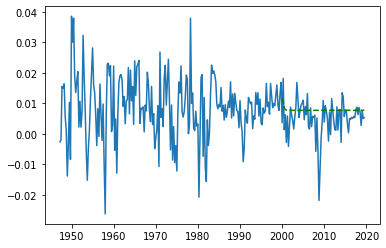

In [195]:
fit_ARMA(log_usgdp_diff, 1, 2, '2000-01-01','2019-07-01')

# Optymalna wartość $p$ na podstawie kryterium oceniającego dobroć dopasowania modelu (AIC lub BIC)

## Zadanie 4
Napisz funkcję, która dla danego szeregu czasowego wyznaczy najlepszy rząd $p$ modelu $\text{AR}(p)$ na podstawie kryterium AIC i BIC.

In [196]:
import warnings
warnings.filterwarnings('ignore')

def find_the_best_parametr_ar(ts, max_p = 10):
    aic = np.zeros(max_p)
    bic = np.zeros(max_p)
    for i in range(1, max_p + 1):
        ar = ARIMA(endog = ts, order = (i, 0, 0)).fit()
        aic[i-1] = ar.aic
        bic[i-1] = ar.bic
        
    plt.plot(range(1, max_p + 1), aic, 'r.-', label="AIC")
    plt.plot(range(1, max_p + 1), bic, 'g.-', label="BIC")
    plt.legend()
    plt.show()
        
    print("Najlepszy rząd p: {} dla kryterium AIC (AIC={})".format(np.argmin(aic) + 1, np.min(aic)))
    print("Najlepszy rząd p: {} dla kryterium BIC (BIC={})".format(np.argmin(bic) + 1, np.min(bic)))

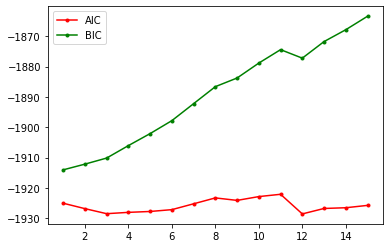

Najlepszy rząd p: 12 dla kryterium AIC (AIC=-1928.5741489457407)
Najlepszy rząd p: 1 dla kryterium BIC (BIC=-1914.0387124270203)


In [197]:
find_the_best_parametr_ar(log_usgdp_diff.GDPC1, 15) #robimy wykres gdzie zobaczymy, który AR najlepiej działa (ma najmniejsze AIC lub BIC)

In [198]:
ARIMA(log_usgdp_diff, order = (1, 0, 0)).fit()

AIC: -1925.05, 
BIC: -1914.04
Statystyka Durbina-Watsona 2.0759947454055205
Pvalue testu Shapiro-Wilka: 2.0925512217218056e-05
MSE: 8.640470538817343e-05
MAE: 0.004720928500725151


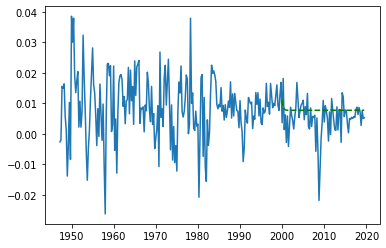

In [199]:
fit_ARMA(log_usgdp_diff, 1, 0, '2000-01-01','2019-07-01')

## Zadanie 5

Napisz funkcję, która dla danego szeregu czasowego wyznaczy najlepszy rząd $p$ i $q$ modelu $\text{ARMA}(p)$ na podstawie kryterium AIC i BIC.

In [200]:
def find_the_best_arma(ts, max_p = 10, max_q=10):
    aic = np.zeros((max_p, max_q))
    bic = np.zeros((max_p, max_q))
    
    for i in range(max_p):
        for j in range(max_q):
            arma = ARIMA(ts, order=(i + 1, 0, j + 1)).fit()
            aic[i, j] = arma.aic
            bic[i, j] = arma.bic
            print('ARMA(%d, %d): AIC=%f, BIC=%f' % (i+1, j+1, arma.aic, arma.bic))
            
    print("-" * 30)
    min_aic = np.min(aic)
    min_arg_aic = np.argwhere(aic == min_aic)[0]
    print("MINIMUM AIC=%f dla p=%d, q=%d" % (min_aic, min_arg_aic[0] + 1, min_arg_aic[1] + 1))
    min_bic = np.min(bic)
    min_arg_bic = np.argwhere(bic == min_bic)[0]
    print("MINIMUM BIC=%f dla p=%d, q=%d" % (min_bic, min_arg_bic[0] + 1, min_arg_bic[1] + 1))

In [201]:
find_the_best_arma(log_usgdp_diff, 5, 5)

ARMA(1, 1): AIC=-1925.127489, BIC=-1910.447966
ARMA(1, 2): AIC=-1928.021677, BIC=-1909.672273
ARMA(1, 3): AIC=-1925.852781, BIC=-1903.833496
ARMA(1, 4): AIC=-1924.802306, BIC=-1899.113139
ARMA(1, 5): AIC=-1926.820312, BIC=-1897.461265
ARMA(2, 1): AIC=-1924.064532, BIC=-1905.715128
ARMA(2, 2): AIC=-1928.031774, BIC=-1906.012488
ARMA(2, 3): AIC=-1925.961944, BIC=-1900.272778
ARMA(2, 4): AIC=-1923.392907, BIC=-1894.033860
ARMA(2, 5): AIC=-1923.751892, BIC=-1890.722964
ARMA(3, 1): AIC=-1925.866200, BIC=-1903.846915
ARMA(3, 2): AIC=-1924.194279, BIC=-1898.505112
ARMA(3, 3): AIC=-1926.153600, BIC=-1896.794553
ARMA(3, 4): AIC=-1923.175145, BIC=-1890.146217
ARMA(3, 5): AIC=-1919.670104, BIC=-1882.971295
ARMA(4, 1): AIC=-1925.598859, BIC=-1899.909692
ARMA(4, 2): AIC=-1923.035771, BIC=-1893.676723
ARMA(4, 3): AIC=-1925.191439, BIC=-1892.162511
ARMA(4, 4): AIC=-1921.581204, BIC=-1884.882395
ARMA(4, 5): AIC=-1916.604487, BIC=-1876.235796
ARMA(5, 1): AIC=-1926.191361, BIC=-1896.832313
ARMA(5, 2): A

AIC: -1925.13, 
BIC: -1910.45
Statystyka Durbina-Watsona 2.002273748524627
Pvalue testu Shapiro-Wilka: 2.451637919875793e-05
MSE: 8.64548134152533e-05
MAE: 0.004706754926860061


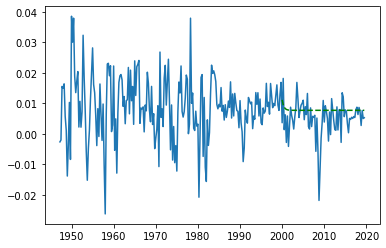

In [202]:
fit_ARMA(log_usgdp_diff, 1, 1, '2000-01-01','2019-07-01') #dla BIC

AIC: -1928.03, 
BIC: -1906.01
Statystyka Durbina-Watsona 2.0011718808840215
Pvalue testu Shapiro-Wilka: 1.2548273844004143e-05
MSE: 8.649283212705271e-05
MAE: 0.004711463360302813


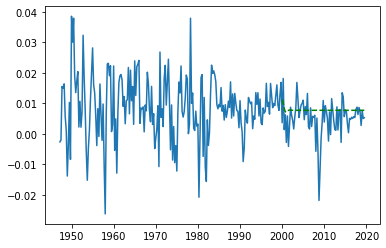

In [203]:
fit_ARMA(log_usgdp_diff, 2, 2, '2000-01-01', '2019-07-01') #dla AIC